In [1]:
import glob
import json
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

PATH = os.path.join(os.path.expanduser('~'), 'probspace-minpaku-pricing')
if PATH not in sys.path:
    sys.path.append(PATH)
from scripts.feature_engineering import LocationClustering

%matplotlib inline

In [2]:
%%time
!jupyter nbconvert --to notebook --execute notebooks\031.ipynb --debug --inplace --ExecutePreprocessor.timeout=2678400

CPU times: total: 93.8 ms
Wall time: 5min 24s


[NbConvertApp] Searching ['C:\\Users\\nndropout\\probspace-minpaku-pricing', 'C:\\Users\\nndropout\\.jupyter', 'C:\\Users\\nndropout\\probspace-minpaku-pricing\\.venv\\etc\\jupyter', 'C:\\ProgramData\\jupyter'] for config files
[NbConvertApp] Looking for jupyter_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Loaded config file: C:\Users\nndropout\.jupyter\jupyter_nbconvert_config.json
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Use

In [3]:
%%time
!jupyter nbconvert --to notebook --execute notebooks\032.ipynb --debug --inplace --ExecutePreprocessor.timeout=2678400

CPU times: total: 203 ms
Wall time: 5min 35s


[NbConvertApp] Searching ['C:\\Users\\nndropout\\probspace-minpaku-pricing', 'C:\\Users\\nndropout\\.jupyter', 'C:\\Users\\nndropout\\probspace-minpaku-pricing\\.venv\\etc\\jupyter', 'C:\\ProgramData\\jupyter'] for config files
[NbConvertApp] Looking for jupyter_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Looking for jupyter_config in C:\Users\nndropout\probspace-minpaku-pricing
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\ProgramData\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\probspace-minpaku-pricing\.venv\etc\jupyter
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Users\nndropout\.jupyter
[NbConvertApp] Loaded config file: C:\Users\nndropout\.jupyter\jupyter_nbconvert_config.json
[NbConvertApp] Looking for jupyter_nbconvert_config in C:\Use

## 前処理ネタ

1. `name` に含まれる情報はクレンジングしておきたい
1. `name` の埋め込みベクトル、文字列長さ、単語数
  - `name` の言語はほぼ日本語、英語、中国語。まれにハングルがあるが両の手にすら満たない数かも。
  - FastText の言語識別モデルの結果は信用できそう。日本語英語中国語以外は英語で処理する。ハングルは90%超えたら信用できそうだ数は少ない。
  - [このノート](notebooks/nameって何語なの？.ipynb)
1. 今のレビュー数を得るのに何か月かかったのか
1. `host_id` のエンコーディング
    1. Frequency encoding
    1. レビュー履歴を集計する
    1. Cross table 集計で持っている物件の特徴を定量化（`neighbourhood`, `room_type` あたりがよさそう）
1. 最寄り駅 Top $N$ の名前と距離
    1. 駅名の重複に注意
    1. "押上（スカイツリー前）"、押上〈スカイツリー前〉の2つが存在するので注意（経度緯度は同じなので削除）
1. 経度緯度
    1. クラスタリングしてセントロイドからの距離を測る（場所が個性的度）
      - 多分クラスタ数は 9, 10 がちょうど良さそう
    1. 自身から $N$ の距離内の駅数（利便性の尺度？）
    1. 自身から $N$ の距離内の民泊数（競争過密度？）

1. 同じ価格の民泊がたくさんありそう？調べてみる。


## やってみたいこと

|No|CV|
|---:|:---|
|1|特徴量：`neighbourhood`, `latitude`, `longitude`, `room_type`, `minimum_nights`, `number_of_reviews`, `reviews_per_month`, `availability_365`, `review_date`, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|v
|2|特徴量：2 + `name` を train と test で共有されていなければ専用の値でマスク, CV: StratifiedKfold(`neighborhood`), モデル：CatBoost|
|3|特徴量：2 + `name` を Tf-IDF+LSIで64次元のベクトルに 
|4|特徴量：2 + `name` を Tf-IDF+LDAで64次元のベクトルに 
|5|特徴量：2 + `name` を Tf-IDF+NMFで64次元のベクトルに
|6|特徴量：2 + `name` を Tf-IDF+LSIで32次元のベクトルに 
|7|特徴量：2 + `name` を Tf-IDF+LDAで32次元のベクトルに 
|8|特徴量：2 + `name` を Tf-IDF+NMFで32次元のベクトルに
|9|特徴量：2 + `name` を Tf-IDF+LSIで16次元のベクトルに 
|10|特徴量：2 + `name` を Tf-IDF+LDAで16次元のベクトルに 
|11|特徴量：2 + `name` を Tf-IDF+NMFで16次元のベクトルに
|12|No.3 の Fold を StratifiedKFold(`y`を binning したやつ) + `name` はクレンジング|
|13|No.3 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|14|No.5 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|15|No.5 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|16|No.6 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|17|No.6 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|18|No.8 の Fold を StratifiedKFold(`y`を binning したやつ)+ `name` はクレンジング|
|19|No.8 の Fold を GroupKFold(`host_id`)+ `name` はクレンジング|
|20|No.5 に `name` のクレンジングを忘れていたので追加|
|21|No.20 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|22|No.14 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|23|No.15 に今のレビュー数を得るのに何か月かかったのかの特徴量を追加|
|24|No.20 にクラスタリングの特徴量を追加, クラスタ数は9|
|25|No.14 にクラスタリングの特徴量を追加, クラスタ数は9|
|26|No.15 にクラスタリングの特徴量を追加, クラスタ数は9|
|27|No.20 にクラスタリングの特徴量を追加, クラスタ数は10|
|28|No.14 にクラスタリングの特徴量を追加, クラスタ数は10|
|29|No.15 にクラスタリングの特徴量を追加, クラスタ数は10|
|30|No.20 に最寄り駅の特徴量を追加|
|31|No.14 に最寄り駅の特徴量を追加|
|32|No.15 に最寄り駅の特徴量を追加|
|33|No.20 に近くの民泊数の特徴量を追加|
|34|No.14 に近くの民泊数の特徴量を追加|
|35|No.15 に近くの民泊数の特徴量を追加|
|36|No.2 に `name` のクレンジング + BERTベクトル化した結果を追加 + Fold は StratifiedKFold(`neighbourhood`)|
|37|No.2 に `name` のクレンジング + BERTベクトル化した結果を追加 + Fold は StratifiedKFold(`y`を binning したやつ)|
|38|No.2 に `name` のクレンジング + BERTベクトル化した結果を追加 + Fold は GroupKFold(`host_id`)|
|39|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた BERT によるベクトル化 + Fold は StratifiedKFold(`neighbourhood`)|
|40|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた BERT によるベクトル化 + Fold は StratifiedKFold(`y`を binning したやつ)|
|41|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた BERT によるベクトル化 + Fold は GroupKFold(`host_id`)|
|42|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + NMFで64次元に + Fold は StratifiedKFold(`neighbourhood`)|
|43|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + NMFで64次元に + Fold は StratifiedKFold(`y`を binning したやつ)|
|44|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + NMFで64次元に+ Fold は GroupKFold(`host_id`)|
|45|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + LSIで64次元に + Fold は StratifiedKFold(`neighbourhood`)|
|46|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + LSIで64次元に + Fold は StratifiedKFold(`y`を binning したやつ)|
|47|No.2 に `name` のクレンジング + FastText による言語予測結果 + 言語に応じた形態素解析 + LSIで64次元に+ Fold は GroupKFold(`host_id`)|

- 2022-04-28  
  - No.11 まで実施するも CV vs LB の並びが気に食わない。相関は強そうだがロスに差があるのはさておき順位が一致しないのが気持ち悪い。StratifiedKFold(`neighbourhood`)以外の方法も試して信頼できる CV を探したい。No.3, 5, 6, 8 を対象に以下を試す。
    - StratifiedKFold: `y`を binning して bin を層とみなす
    - GroupKFold(`host_id`): [このDiscussion](https://comp.probspace.com/competitions/bnb_price/discussions/shirapon24-Postde0ee1e20bc5d402eea0) でやってる人がいる。

- 2022-04-30  
  - No.12-19 を行い5サブ使って CV と LB の相関を確認する。相関はしているが CV と LB とで順位が合わないことがあり気持ち悪い。
  - No.44 までつらつらと書き連ねた。
  - 今のレビュー数を得るのに何か月かかったのかの特徴量は無い方が良い？
  - 同じ `name` で場所も同じっぽいのに `host_id` が違うと価格が大きく変わることがある。`host_id` から予測に役立つ情報をどう抽出するのか？を考えられたらスコア大きく伸びるかも？
  - No.19 以降は表の番号と実際のノートがあっていないかもしれないから要チェック。
  
- 2022-05-01
  - 024 の途中で `name` のクレンジングを間違えて test の一部が欠損していることに気づいたから修正した

## CV vs LB

In [4]:
lb = [
    ('001', 0.86378),
    ('002', np.nan),  # `y` を対数変換せずに学習して Submit したので他と比べられない
    ('003', 0.82206),
    ('004', 0.85716),
    ('005', 0.80957),
    ('006', 0.82747),
    ('007', 0.84814),
    ('008', 0.82104),
    ('009', 0.83919),
    ('010', 0.86311),
    ('011', 0.83046),
    ('012', 0.82092),
    ('013', 0.82579),
    ('014', 0.80827),
    ('015', 0.80948),
    ('016', 0.82307),
    ('017', 0.83054),
    ('018', 0.81970),
    ('019', 0.82118),
    ('020', 0.80767),
    ('021', 0.80968)

]
lb = pd.DataFrame(lb, columns=['No', 'LB'])
assert not lb['No'].duplicated().any()
lb

,No,LB
0,001,0.86378
1,002,NaN
2,003,0.82206
3,004,0.85716
4,005,0.80957
5,006,0.82747
6,007,0.84814
7,008,0.82104
8,009,0.83919
9,010,0.86311


In [5]:
cv = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'result.json')):
    with open(filepath, 'r') as f:
        cv.append(json.load(f))
cv = pd.DataFrame(cv)
cv

,No,CV,Fold
0,001,0.694386,NaN
1,002,0.697720,NaN
2,003,0.589649,NaN
3,004,0.667733,NaN
4,005,0.590896,NaN
5,006,0.600847,NaN
6,007,0.674444,NaN
7,008,0.604754,NaN
8,009,0.610643,NaN
9,010,0.677813,NaN


In [6]:
cv_vs_lb = pd.merge(cv, lb, how='left').set_index('No')
cv_vs_lb['Fold'].fillna('StratifiedKFold(neighbourhood)', inplace=True)
cv_vs_lb['Rank(CV)'] = cv_vs_lb['CV'].rank().astype('int')
cv_vs_lb['Rank(LB)'] = cv_vs_lb['LB'].rank()
cv_vs_lb = cv_vs_lb[['Fold', 'CV', 'LB', 'Rank(CV)', 'Rank(LB)']]
cv_vs_lb.sort_values(['Fold', 'Rank(CV)'])

,Fold,CV,LB,Rank(CV),Rank(LB)
No,,,,,
015,GroupKFold(host_id),0.808273,0.80948,25,3.0
026,GroupKFold(host_id),0.812896,NaN,26,NaN
032,GroupKFold(host_id),0.813653,NaN,27,NaN
029,GroupKFold(host_id),0.813925,NaN,28,NaN
023,GroupKFold(host_id),0.820614,NaN,29,NaN
017,GroupKFold(host_id),0.825099,0.83054,30,15.0
013,GroupKFold(host_id),0.830990,0.82579,31,12.0
019,GroupKFold(host_id),0.831398,0.82118,32,9.0
024,StratifiedKFold(neighbourhood),0.588838,NaN,1,NaN


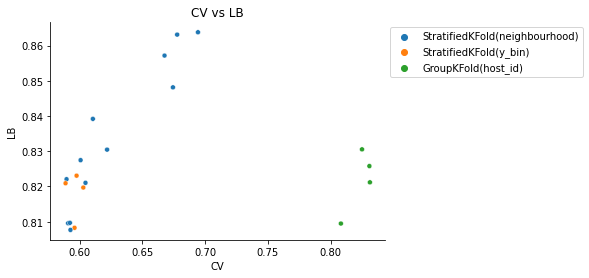

In [7]:
fig, _ = plt.subplots(nrows=1, ncols=1, sharex=True,sharey=True)
ax = sns.scatterplot(data=cv_vs_lb, x='CV', y='LB', hue='Fold', s=24)
ax.legend(loc='upper left', bbox_to_anchor=[1., 1.])
ax.set_title('CV vs LB')
sns.despine()

In [8]:
cv_vs_lb.groupby('Fold').corr()

CV        LB  Rank(CV)  \
Fold                                                                    
GroupKFold(host_id)            CV        1.000000  0.772525  0.973108   
                               LB        0.772525  1.000000  0.763015   
                               Rank(CV)  0.973108  0.763015  1.000000   
                               Rank(LB)  0.733283  0.998110  0.721930   
StratifiedKFold(neighbourhood) CV        1.000000  0.938060  0.852305   
                               LB        0.938060  1.000000  0.828698   
                               Rank(CV)  0.852305  0.828698  1.000000   
                               Rank(LB)  0.835538  0.953434  0.796914   
StratifiedKFold(y_bin)         CV        1.000000 -0.007198  0.932437   
                               LB       -0.007198  1.000000 -0.176016   
                               Rank(CV)  0.932437 -0.176016  1.000000   
                               Rank(LB)  0.003047  0.914312 -0.035829   

                                         Rank(LB)  
Fold                                               
GroupKFold(host_id)            CV        0.733283  
                               LB        0.998110  
                               Rank(CV)  0.721930  
                               Rank(LB)  1.000000  
StratifiedKFold(neighbourhood) CV        0.835538  
                               LB        0.953434  
                               Rank(CV)  0.796914  
                               Rank(LB)  1.000000  
StratifiedKFold(y_bin)         CV        0.003047  
                               LB        0.914312  
                               Rank(CV) -0.035829  
                               Rank(LB)  1.000000

## Submissions

In [9]:
submissions = []
for filepath in glob.glob(os.path.join('notebooks', '*', 'submission*.csv')):
    sub = pd.read_csv(filepath).set_index('id').rename(columns={'y': os.path.basename(filepath).replace('.csv', '')})
    submissions.append(sub)
submissions = pd.concat(submissions, axis=1)
submissions

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,...,submission_023,submission_024,submission_025,submission_026,submission_027,submission_028,submission_029,submission_030,submission_031,submission_032
id,,,,,,,,,,,,,,,,,,,,,
1,15563.757288,15412.997055,15149.523135,13178.117184,11980.825061,10508.393906,15667.459837,11324.098572,12065.894615,14905.229225,...,14419.796093,16206.881638,15386.802498,16786.292382,16597.584793,15609.081323,15823.252701,16253.897092,14621.960608,17699.943294
2,11315.311473,11800.884838,16759.002170,18896.921538,17543.344321,18547.891042,15522.055171,19381.293858,13768.671233,13016.722028,...,17316.461720,16836.442118,17560.705385,16586.252677,17622.791325,17792.359017,15512.766160,14130.504001,14470.844353,13653.080015
3,15921.739860,15458.861373,12868.850477,13833.183047,8661.947943,14978.764058,14609.431020,12749.191746,14776.633311,13855.485504,...,10738.058366,10223.928123,10838.213835,11810.854247,11495.448093,13267.600333,11738.701853,11559.778152,13597.548314,12015.640804
4,18301.790676,17935.568540,18215.072414,18200.361440,13063.205844,17165.856038,13294.381434,11831.085654,13983.897808,16297.975643,...,12778.420779,13987.281209,13613.303315,13793.750203,13552.933826,13538.459008,12494.680592,16455.080811,16191.077548,15519.491942
5,16902.712775,17462.485144,13713.515681,10807.210259,17727.311670,16046.239749,10672.610902,19578.740872,13694.180372,12693.326009,...,15800.878805,18858.374134,18977.490432,19280.524750,15123.033078,16212.856283,17029.630486,18901.156083,20010.329539,17103.344159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,16205.214315,17100.410596,16314.733135,15171.650792,19556.640976,14094.964825,16362.980911,13140.105071,13840.264147,15989.095466,...,20381.007759,22101.031523,21379.582021,22291.764197,21896.263953,20674.653925,20558.279688,21005.794953,21094.532291,20791.563424
4993,5677.865217,5358.291104,5948.367432,3948.394058,7428.852594,5898.345846,4168.222473,5514.551350,5488.185618,4596.088497,...,6931.101749,6967.278752,6786.983895,7262.248344,6406.583374,6590.585839,6559.056801,5778.180542,5748.015547,5948.820092
4994,12993.019405,13360.993708,12191.612305,8989.510602,9128.376238,10654.646137,14195.483591,13188.754774,9980.230906,14370.268756,...,8015.135094,7426.241612,7748.694835,7263.875398,7590.131546,7463.327728,7711.033790,8690.302969,9222.700877,9045.041327


In [10]:
corr = submissions.corr()
corr

,submission_001,submission_002,submission_003,submission_004,submission_005,submission_006,submission_007,submission_008,submission_009,submission_010,...,submission_023,submission_024,submission_025,submission_026,submission_027,submission_028,submission_029,submission_030,submission_031,submission_032
submission_001,1.000000,0.992997,0.636294,0.709383,0.539525,0.626795,0.742152,0.614587,0.669529,0.777660,...,0.603576,0.579818,0.572748,0.611517,0.565032,0.543127,0.615508,0.617851,0.587968,0.627148
submission_002,0.992997,1.000000,0.638716,0.713171,0.538779,0.627931,0.746296,0.615483,0.670174,0.781966,...,0.605280,0.580424,0.572445,0.613354,0.564557,0.543114,0.616415,0.619199,0.589031,0.629773
submission_003,0.636294,0.638716,1.000000,0.745140,0.703509,0.924160,0.729231,0.812588,0.885452,0.726250,...,0.768025,0.753615,0.739656,0.779332,0.717500,0.691204,0.767197,0.735620,0.712269,0.722636
submission_004,0.709383,0.713171,0.745140,1.000000,0.599688,0.734037,0.872784,0.685876,0.737677,0.882376,...,0.668959,0.636648,0.627072,0.673956,0.611280,0.589415,0.667102,0.638062,0.618586,0.647995
submission_005,0.539525,0.538779,0.703509,0.599688,1.000000,0.672951,0.584961,0.826826,0.640432,0.607285,...,0.951876,0.952809,0.953452,0.943075,0.954683,0.941074,0.944151,0.938224,0.942253,0.917974
submission_006,0.626795,0.627931,0.924160,0.734037,0.672951,1.000000,0.724703,0.820976,0.932568,0.725500,...,0.744082,0.723687,0.710971,0.756347,0.687678,0.662984,0.744414,0.708823,0.685987,0.702551
submission_007,0.742152,0.746296,0.729231,0.872784,0.584961,0.724703,1.000000,0.681112,0.736974,0.890258,...,0.651987,0.617652,0.608131,0.654558,0.591945,0.570273,0.649361,0.629873,0.607247,0.641274
submission_008,0.614587,0.615483,0.812588,0.685876,0.826826,0.820976,0.681112,1.000000,0.787521,0.692764,...,0.867106,0.860072,0.856445,0.873104,0.847503,0.831367,0.872810,0.853618,0.841121,0.849588
submission_009,0.669529,0.670174,0.885452,0.737677,0.640432,0.932568,0.736974,0.787521,1.000000,0.747692,...,0.721166,0.692969,0.680592,0.736019,0.657491,0.635659,0.721254,0.688525,0.665690,0.690421
submission_010,0.777660,0.781966,0.726250,0.882376,0.607285,0.725500,0.890258,0.692764,0.747692,1.000000,...,0.674411,0.648028,0.644169,0.681784,0.627761,0.613963,0.679368,0.650798,0.630332,0.658293


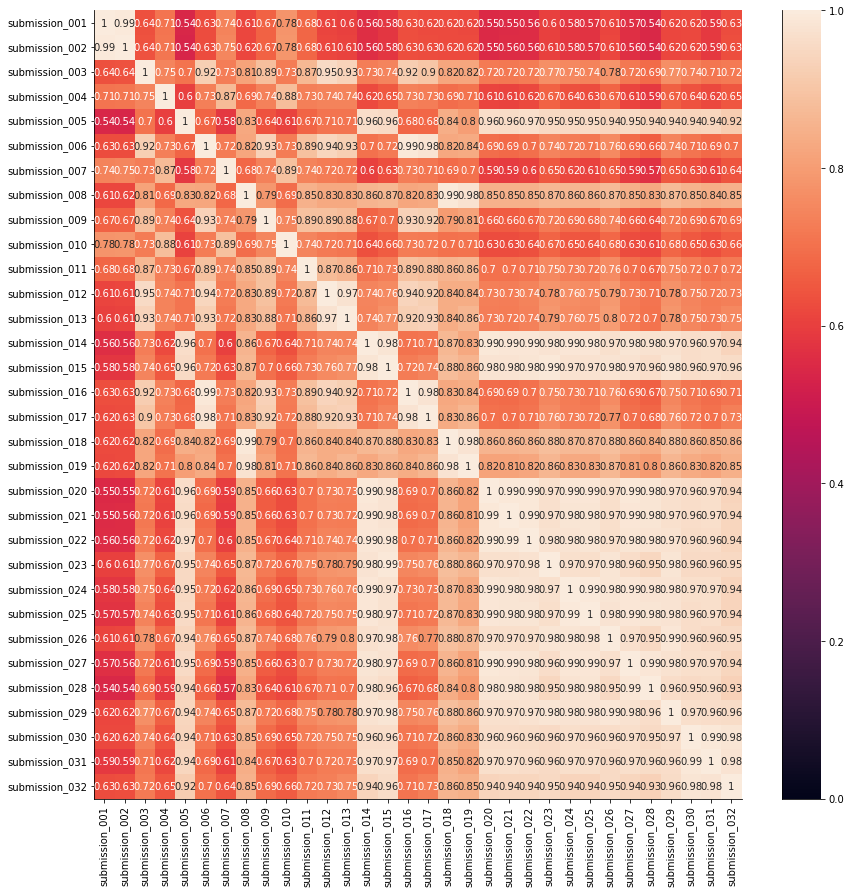

In [11]:
fig = plt.figure(figsize=(14.5, 14.5))
sns.heatmap(corr, annot=True, vmin=0., vmax=1.)
sns.despine()